# Figure 4 (reverse correlation)
The goal of this experiment is to estimate the dynamics of the optic flow memory using noisy velocity inputs and the reverse correlation.

Fish observed forward/backward stimuli (open-loop) flowing at 15 mm/s that switches directions randomly with a 0.5 Hz Poisson process.

In [3]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
from scipy.stats import wilcoxon, binned_statistic
import colorcet as cc
from homr_util import *
from tqdm import tqdm

In [4]:
# Tweaking matplotlib 
set_rcParams()

In [5]:
# Find data
data_dir = "./data/fig4"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 29 fish


## Analysis
- Average stimuli preceding bout onset, weighted by bout vigor (bout-triggered-average, *BTA*)
- A proper reverse correlation analysis would require matrix division by stimulus autocorrelation. We figured the amount of data we have makes it impossible to do this (things get too noisy).

#### Parameters

In [6]:
kernel_shift = 0 # in s 
kernel_duration = 15 # in s
kernel_resolution = 5 # in Hz

# prepare vector
kernel_t_vec = np.arange(kernel_duration-kernel_shift, -kernel_shift, -1/kernel_resolution)

# inclusion criteria of fish
min_freq = 0.05      # in Hz, minimum total bout frequency
bias_threshold = 1.0 # bouts with bias higher than this will not be included

In [18]:
all_BTA = []

# loop through fish
for fish in tqdm(fish_list):
        
    # pull out data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    bouts = exp.get_bouts()
    
    # proceed only if we have enough bouts
    if len(bouts) >= 60 * 60 * min_freq:

        ## pull out time series
        # timestamp
        t_s = exp.stimulus_log['t'].to_numpy()
        # pull out bouts from bouter
        bsum = exp.get_bout_properties()
        # stimulus (in mm/s)
        stim = exp.stimulus_log['LDPS_drift_direction']  * 15
        
        # Here, I multiple 30 mm/s/rad on vigor to convert vigor (which is std of tail bend in rad) 
        # to swim velocity, in accordance with the "gain 1" condition in the closed loop experiments,
        # which makes more sense as the unit of BTA
        vig = bsum['peak_vig'].to_numpy() * 30
        bias = bsum['bias'].to_numpy()
        t_bout = bsum['t_start'].to_numpy()

        # remove bouts too early, too late, or too biased
        too_early = t_bout <= kernel_duration - kernel_shift
        too_late  = t_bout > t_s[-1] - kernel_duration + kernel_shift
        too_turny = np.abs(bias)>bias_threshold
        not_too_early_or_late = ~too_early * ~too_late * ~too_turny
        
        n_valid_bout = np.sum(not_too_early_or_late)

        # downsample stimulus
        t_edge = np.arange(t_s[0], t_s[-1], 1/kernel_resolution)
        t_cen  = (t_edge[:-1]+t_edge[1:])/2
        ds_stim = binned_statistic(t_s, stim, 'mean', t_edge)[0]
        ind_bout = np.argmin(np.abs(t_bout[not_too_early_or_late,None]-t_cen[None,:]),axis=1)

        # create 2d array for indexes corresponding to the stimulus matrix
        ind_mat = ind_bout[:,None] + np.arange( -(kernel_duration-kernel_shift)*kernel_resolution, kernel_shift*kernel_resolution,)[None,:]

        # stimulus matrix
        s_mat = ds_stim[ind_mat]
        s_mat[np.isnan(s_mat)] = 0

        # Bout triggered averages
        BTA = np.matmul(s_mat.T, vig[not_too_early_or_late]) / n_valid_bout
        
        # log data
        all_BTA.append(BTA)

all_BTA = np.asarray(all_BTA)

100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:15<00:00,  1.89it/s]


In [9]:
# Fit exponential on individual BTA
n_good_fish = all_BTA.shape[0]
taus = np.empty(n_good_fish)
betas = np.empty(n_good_fish)
for i in range(n_good_fish):
    taus[i], betas[i], _ = fit_exponential_direct(all_BTA[i, :], kernel_duration, kernel_resolution)

In [10]:
# Fit exponential on average BTA
mean_BTA = np.mean(all_BTA, axis=0)
mean_tau, mean_beta, _ = fit_exponential_direct(mean_BTA, kernel_duration, kernel_resolution)

## Panels
### Fig. 4A (Individual fish example)

In [14]:
fid = 2 # example fish

show_range = (600, 700) # pull out 100 s segment during which there are not too many bouts

# need to re-open data, because we didn't save raw traces for the sake of memory 
exp = EmbeddedExperiment(data_dir + '/' + fish_list[fid])
slog = exp['stimulus']['log']
bouts = exp.get_bouts()
bsum = exp.get_bout_properties()

t_s = exp.stimulus_log['t'].to_numpy()
stim = exp.stimulus_log['LDPS_drift_direction'].to_numpy() * 15
t_b = exp.behavior_log['t'].to_numpy()
tail_sum = exp.behavior_log['tail_sum'].to_numpy() / np.pi * 180

vig = bsum['peak_vig'].to_numpy() * 30
bias = bsum['bias'].to_numpy()
t_bout = bsum['t_start'].to_numpy()

good_bout = (np.abs(bias) <= bias_threshold) * (t_bout > show_range[0]) * (t_bout < show_range[1])

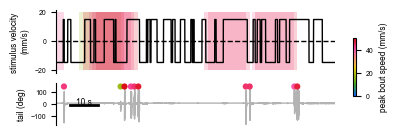

In [15]:
fig, ax = plt.subplots(2, 1, height_ratios=(1.5,1), figsize=(4.5, 1.5))

cmap = cc.cm.CET_R3
max_vig = 50

# raw stimulus trace
ax[0].plot(t_s, stim, color=(0,0,0), zorder=3)
ax[0].plot([0,2000],[0,0],'k--')
for t_end, this_vig in zip(t_bout[good_bout], vig[good_bout]):
    ax[0].fill_between((t_end-kernel_duration, t_end), (20,20), (-20,-20), alpha=0.2, color=cmap(this_vig/max_vig))

# tail trace with bouts indicated as dots
ax[1].plot(t_b, tail_sum, lw=1, color=(0.7,0.7,0.7))
sc = ax[1].scatter(t_bout[good_bout], 150 + 0*vig[good_bout], c=vig[good_bout], s=20, cmap=cmap, vmax=max_vig, vmin=0, zorder=3)
ax[1].plot((show_range[0]+5, show_range[0]+15), [-5,-5], 'k-', lw=2)
ax[1].text(show_range[0]+7, -4, '10 s')
cb = plt.colorbar(sc, ax=ax, location='right', shrink=0.5)
cb.set_label('peak bout speed (mm/s)')

# axis management
ax[0].set_xlim(show_range[0], show_range[1])
ax[1].set_xlim(show_range[0], show_range[1])
ax[0].set_ylim(-22, 22)
ax[1].set_ylim(-180, 180)

ax[0].set_ylabel('stimulus velocity \n(mm/s)')
ax[1].set_ylabel('tail (deg)')


toggle_spines(ax[0], 0, 0, 0, 1)
toggle_spines(ax[1], 0, 0, 0, 1)


plt.savefig('./svgs/Fig4A.svg', format='svg')
plt.show()

### Fig. 4B (Example fish BTA with fitting)

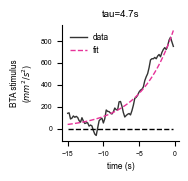

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(1.5,1.5))
ax.plot(-kernel_t_vec, all_BTA[fid, :], color=(0.2,0.2,0.2), label='data')
ax.plot(-kernel_t_vec, np.exp(kernel_t_vec/taus[fid]) * np.exp(betas[fid]), linestyle='--', color=(0.9,0.2,0.6), label='fit')
ax.plot(-kernel_t_vec, kernel_t_vec*0, 'k--')
ax.set_title('tau={:0.2}s'.format(-taus[fid]))
ax.legend(frameon=False)
ax.set_ylabel('BTA stimulus\n($mm^2/s^2$)')
ax.set_xlabel('time (s)')
toggle_spines(ax, 0, 1, 0, 1)
plt.savefig('./svgs/Fig4B.svg', format='svg')
plt.show()

### Fig. 4CD (Population average BTA & exponential $\tau$)

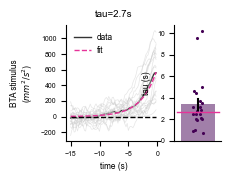

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(2, 1.5), width_ratios=(2, 1))

ax[0].plot(-kernel_t_vec, mean_BTA, color=(0.2,0.2,0.2), label='data')
ax[0].plot(-kernel_t_vec, all_BTA.T, color=(0.8,0.8,0.8), lw=0.5, alpha=0.5)
ax[0].plot(-kernel_t_vec, np.exp(kernel_t_vec/mean_tau) * np.exp(mean_beta), linestyle='--', color=(0.9,0.2,0.6), label='fit')
ax[0].plot(-kernel_t_vec, kernel_t_vec*0, 'k--')
ax[0].set_title('tau={:0.2}s'.format(-mean_tau))
ax[0].legend()

scatter_bar([-taus], ax=ax[1])
ax[1].plot([-0.5,0.5], [-mean_tau,-mean_tau], color=(0.9,0.2,0.6), lw=1)
ax[1].set_xticks([])
ax[1].set_ylabel('tau (s)')

ax[0].set_ylabel('BTA stimulus\n($mm^2/s^2$)')
ax[0].set_xlabel('time (s)')

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    
plt.savefig('./svgs/Fig4CD.svg', format='svg')
plt.show()